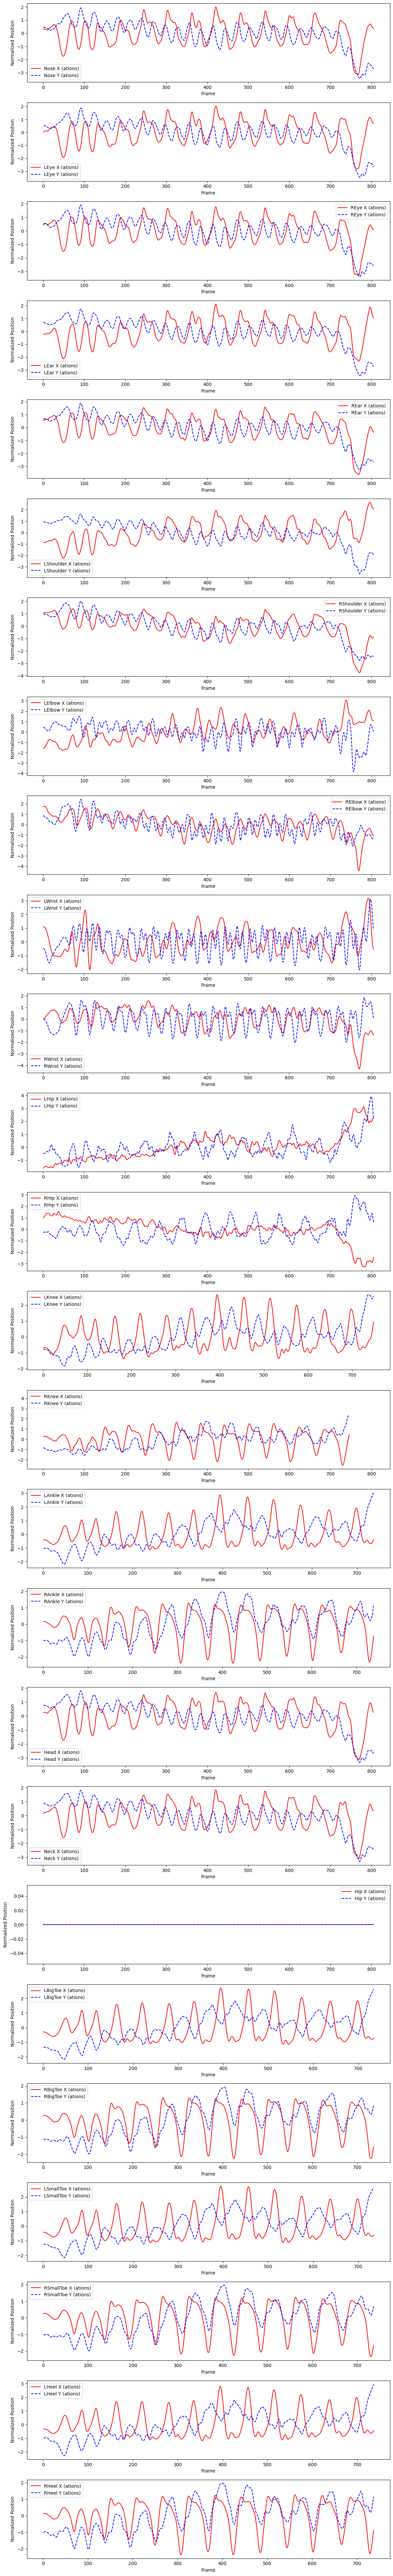

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from scipy.ndimage import gaussian_filter1d  # Gaussian smoothing

# Function to load JSON data
def load_json(file_path):
    with open(file_path, "r") as f:
        return json.load(f)

# List of JSON file paths (update with actual paths)
file_paths = [
    r"C:\awilde\britta\LTU\SkiingProject\SkiersProject\Data\Annotations\DJI_0038_annotations.json",
   #"/Users/emillundin/Desktop/Ski_project/Annotations_from_CVAT/annotations/17_cut.json",
   #"/Users/emillundin/Desktop/Ski_project/Annotations_from_CVAT/annotations/22_cut.json"
]

# Load all datasets
datasets = {file_path: load_json(file_path) for file_path in file_paths}

# Extract keypoint labels (assumes same structure across files)
keypoint_labels = next(iter(datasets.values()))["categories"][0]["keypoints"]
hip_index = keypoint_labels.index("Hip")  # Find the index of the "Hip" keypoint

# Function to compute keypoints relative to the hip position
def compute_relative_keypoints(keypoints):
    """Compute keypoints relative to the hip keypoint."""
    hip_x, hip_y, hip_v = keypoints[hip_index * 3 : hip_index * 3 + 3]
    
    if hip_v == 0:
        return [(None, None)] * (len(keypoints) // 3)

    relative_keypoints = []
    for i in range(0, len(keypoints), 3):
        x, y, v = keypoints[i:i+3]
        if v > 0:
            rel_x = x - hip_x
            rel_y = y - hip_y
        else:
            rel_x = rel_y = None
        relative_keypoints.append((rel_x, rel_y))
    
    return relative_keypoints

# Function to process data from a dataset
def process_data(data):
    frames = sorted(set(anno["image_id"] for anno in data.get("annotations", [])))
    num_keypoints = len(keypoint_labels)
    keypoint_movements = {i: {"x": [], "y": []} for i in range(num_keypoints)}

    for annotation in data.get("annotations", []):
        keypoints = annotation["keypoints"]
        relative_keypoints = compute_relative_keypoints(keypoints)
        
        for idx, (rel_x, rel_y) in enumerate(relative_keypoints):
            keypoint_movements[idx]["x"].append(rel_x)
            keypoint_movements[idx]["y"].append(rel_y)

    return frames, keypoint_movements

# Process all datasets
processed_data = {file_path: process_data(data) for file_path, data in datasets.items()}

# Function to normalize signals using Z-score normalization
def normalize_signal(signal):
    """Normalize the signal using Z-score normalization."""
    signal = np.array(signal, dtype=np.float32)  # Convert to numpy array
    valid_values = signal[~np.isnan(signal)]  # Ignore NaN values

    if len(valid_values) > 1:
        mean = np.mean(valid_values)
        std = np.std(valid_values)
        signal = (signal - mean) / std if std > 0 else signal - mean
    return signal

# Function to apply Gaussian smoothing
def smooth_signal(signal, sigma=2):
    """Apply Gaussian low-pass filter to smooth the signal."""
    return gaussian_filter1d(signal, sigma=sigma, mode="nearest")  # Smoothing filter

# Normalize and smooth all datasets
sigma_value = 2  # Adjust for more or less smoothing

for file_path, (frames, keypoints) in processed_data.items():
    for idx in range(len(keypoint_labels)):
        keypoints[idx]["x"] = normalize_signal(keypoints[idx]["x"])
        keypoints[idx]["y"] = normalize_signal(keypoints[idx]["y"])
        
        keypoints[idx]["x"] = smooth_signal(keypoints[idx]["x"], sigma=sigma_value)
        keypoints[idx]["y"] = smooth_signal(keypoints[idx]["y"], sigma=sigma_value)

# Generate unique colors for each dataset
colors = cycle(["blue", "red", "green", "purple", "orange", "brown", "cyan", "magenta"])

# Plot keypoint movement for all datasets
fig, axs = plt.subplots(len(keypoint_labels), 1, figsize=(12, 3 * len(keypoint_labels)), sharex=False)

for idx in range(len(keypoint_labels)):
    color_cycle = cycle(colors)  # Reset color cycle for each keypoint
    for file_path, (frames, keypoints) in processed_data.items():
        color = next(color_cycle)
        axs[idx].plot(frames, keypoints[idx]["x"], label=f"{keypoint_labels[idx]} X ({file_path[-11:-5]})", linestyle="-", color="red")
        axs[idx].plot(frames, keypoints[idx]["y"], label=f"{keypoint_labels[idx]} Y ({file_path[-11:-5]})", linestyle="--", color="blue")

    axs[idx].set_ylabel("Normalized Position")
    axs[idx].legend()

    axs[idx].set_xlabel("Frame")

plt.tight_layout()
plt.show()

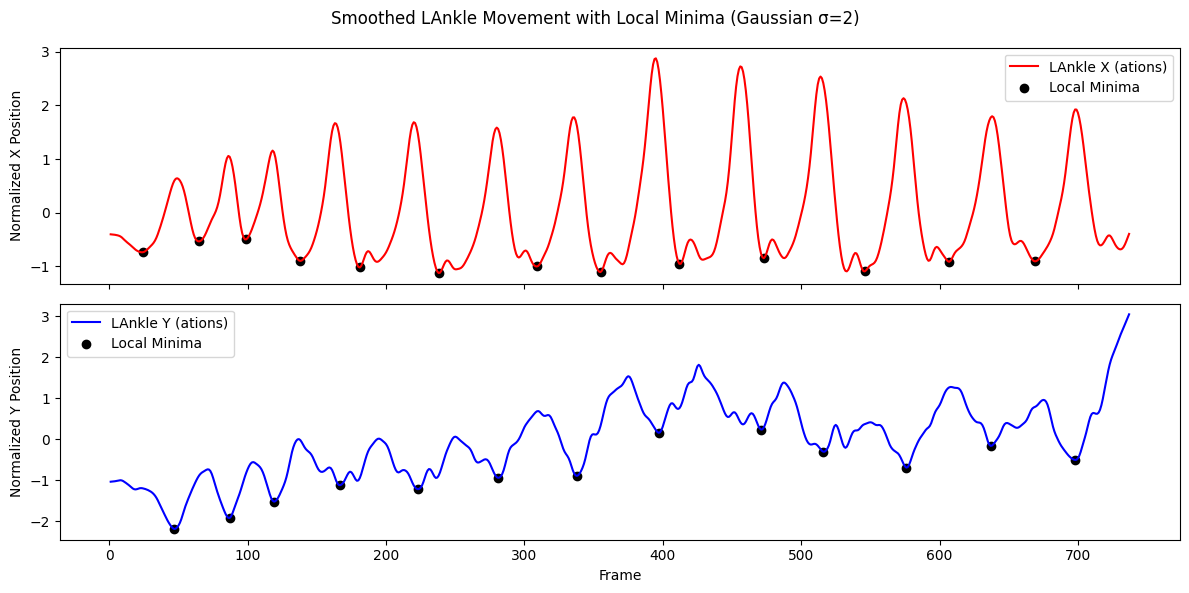

In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d  # Gaussian smoothing
from scipy.signal import argrelextrema  # Local minima detection

# Function to load JSON data
def load_json(file_path):
    with open(file_path, "r") as f:
        return json.load(f)

# List of JSON file paths (update with actual paths)
file_paths = [
    r"C:\awilde\britta\LTU\SkiingProject\SkiersProject\Data\Annotations\DJI_0038_annotations.json",
   #"/Users/emillundin/Desktop/Ski_project/Annotations_from_CVAT/annotations/17_cut.json",
   #"/Users/emillundin/Desktop/Ski_project/Annotations_from_CVAT/annotations/22_cut.json"
]

# Load all datasets
datasets = {file_path: load_json(file_path) for file_path in file_paths}

# Extract keypoint labels (assumes same structure across files)
keypoint_labels = next(iter(datasets.values()))["categories"][0]["keypoints"]
hip_index = keypoint_labels.index("Hip")  # Find the index of the "Hip" keypoint
lankle_index = keypoint_labels.index("LAnkle")  # Find index for Left Ankle

# Function to compute keypoints relative to the hip position
def compute_relative_keypoints(keypoints):
    """Compute keypoints relative to the hip keypoint."""
    hip_x, hip_y, hip_v = keypoints[hip_index * 3 : hip_index * 3 + 3]
    
    if hip_v == 0:
        return [(None, None)] * (len(keypoints) // 3)

    relative_keypoints = []
    for i in range(0, len(keypoints), 3):
        x, y, v = keypoints[i:i+3]
        if v > 0:
            rel_x = x - hip_x
            rel_y = y - hip_y
        else:
            rel_x = rel_y = None
        relative_keypoints.append((rel_x, rel_y))
    
    return relative_keypoints

# Function to process data from a dataset
def process_data(data):
    frames = sorted(set(anno["image_id"] for anno in data.get("annotations", [])))
    keypoint_movements = {"x": [], "y": []}  # Store only LAnkle movement

    for annotation in data.get("annotations", []):
        keypoints = annotation["keypoints"]
        relative_keypoints = compute_relative_keypoints(keypoints)

        # Store only Left Ankle (LAnkle) movements
        lankle_x, lankle_y = relative_keypoints[lankle_index]
        keypoint_movements["x"].append(lankle_x)
        keypoint_movements["y"].append(lankle_y)

    return frames, keypoint_movements

# Process all datasets
processed_data = {file_path: process_data(data) for file_path, data in datasets.items()}

# Function to normalize signals using Z-score normalization
def normalize_signal(signal):
    """Normalize the signal using Z-score normalization."""
    signal = np.array(signal, dtype=np.float32)
    valid_values = signal[~np.isnan(signal)]

    if len(valid_values) > 1:
        mean = np.mean(valid_values)
        std = np.std(valid_values)
        signal = (signal - mean) / std if std > 0 else signal - mean
    return signal

# Function to apply Gaussian smoothing
def smooth_signal(signal, sigma=2):
    """Apply Gaussian low-pass filter to smooth the signal."""
    return gaussian_filter1d(signal, sigma=sigma, mode="nearest")  

# Normalize and smooth all datasets
sigma_value = 2  # Adjust smoothing strength

for file_path, (frames, keypoints) in processed_data.items():
    keypoints["x"] = normalize_signal(keypoints["x"])
    keypoints["y"] = normalize_signal(keypoints["y"])

    keypoints["x"] = smooth_signal(keypoints["x"], sigma=sigma_value)
    keypoints["y"] = smooth_signal(keypoints["y"], sigma=sigma_value)

# Plot LAnkle movement (X and Y in separate plots)
fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

order = 20 # How sensetive to find local minima

for file_path, (frames, keypoints) in processed_data.items():
    # Detect local minima for X movement
    x_values = np.array(keypoints["x"])
    x_min_indices = argrelextrema(x_values, np.less, order=order)[0]  

    # Detect local minima for Y movement
    y_values = np.array(keypoints["y"])
    y_min_indices = argrelextrema(y_values, np.less, order=order)[0]  

    # Plot LAnkle X movement
    axs[0].plot(frames, x_values, label=f"LAnkle X ({file_path[-11:-5]})", color="red")
    axs[0].scatter(np.array(frames)[x_min_indices], x_values[x_min_indices], color="black", marker="o", label="Local Minima")
    axs[0].set_ylabel("Normalized X Position")
    axs[0].legend()

    # Plot LAnkle Y movement
    axs[1].plot(frames, y_values, label=f"LAnkle Y ({file_path[-11:-5]})", color="blue")
    axs[1].scatter(np.array(frames)[y_min_indices], y_values[y_min_indices], color="black", marker="o", label="Local Minima")
    axs[1].set_ylabel("Normalized Y Position")
    axs[1].set_xlabel("Frame")
    axs[1].legend()

plt.suptitle(f"Smoothed LAnkle Movement with Local Minima (Gaussian σ={sigma_value})")
plt.tight_layout()
plt.show()